In [1]:
def in_colab() -> bool:
    try:
        import google.colab  # noqa: F401
        return True
    except Exception:
        return False

In [ ]:
if in_colab():
    !git clone https://github.com/MaxSpeer/applied-computer-vision-assignment2.git
    %cd applied-computer-vision-assignment2
    !pip install -r requirements.txt
    !pip install -e .

fatal: destination path 'applied-computer-vision-assignment2' already exists and is not an empty directory.
/Users/maximilian/code/assessment2/notebooks/applied-computer-vision-assignment2
Obtaining file:///Users/maximilian/code/assessment2/notebooks/applied-computer-vision-assignment2
ERROR: file:///Users/maximilian/code/assessment2/notebooks/applied-computer-vision-assignment2 does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [3]:
from pathlib import Path
import sys
project_root = Path("..").resolve()
sys.path.append(str(project_root))

In [5]:
if in_colab() and INTEGRATE_DATA_FROM_KAGGLE:

    from google.colab import userdata
    import os

    os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
    os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

    assert os.environ["KAGGLE_USERNAME"] and os.environ["KAGGLE_KEY"], "Secrets fehlen/leer"

    import os#, json
    import torch
    from src.datasets import get_torch_xyza, saveToPcdFile, get_tensor_xyza_from_lidar_dir, add_category_to_grouped_dataset_complete_only
    import fiftyone as fo
    import json

    # Paste your kaggle.json content here as a Python dict if you can't upload the file
    kaggle_json = {
        "username": KAGGLE_USERNAME, # <<< REPLACE WITH YOUR KAGGLE USERNAME
        "key": KAGGLE_KEY # <<< REPLACE WITH YOUR KAGGLE KEY
    }

    # Create the dir and write the file
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
        json.dump(kaggle_json, f)

    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

    # Run locally
    # kaggle datasets download -d andandand/cubes-and-spheres-lidar-and-rgb -p data --unzip
    !kaggle datasets download -d andandand/cubes-and-spheres-lidar-and-rgb -p data --unzip
    ################################################################################

    import os
    import numpy as np
    import torch
    import matplotlib.pyplot as plt

    # ----- paths -----
    angle_root = "./data/assessment/cubes"
    # lidar_example = "./data/assessment/cubes/lidar/0048.npy"  # pick any frame

    # ----- load data -----
    # lidar_depth_np = np.load(lidar_example).astype(np.float32)   # (H, W)
    azimuth_np = np.load(os.path.join(angle_root, "azimuth.npy"))  # (H,)
    zenith_np  = np.load(os.path.join(angle_root, "zenith.npy"))   # (W,)

    # to torch, as in your notebook
    # lidar_depth = torch.from_numpy(lidar_depth_np)                # (H, W)
    azimuth = torch.from_numpy(azimuth_np)                        # (H,)
    zenith  = torch.from_numpy(zenith_np)                         # (W,)

    # xyza = get_torch_xyza(lidar_depth, azimuth, zenith)  # (4, H, W)
    # print("xyza shape:", xyza.shape)

    # ------ CUBES lidar data processing -----
    lidar_dir = "./data/assessment/cubes/lidar/"
    output_pcd_dir = "./data/assessment/cubes/lidar_pcd/"

    xyza_tensors = get_tensor_xyza_from_lidar_dir(
        lidar_dir,
        azimuth,
        zenith,
    )
    
    print(f"Successfully computed xyza tensors for {len(xyza_tensors)} lidar files.")
    print(f"Example xyza tensor shape for frame_id '{list(xyza_tensors.keys())[0]}': {xyza_tensors[list(xyza_tensors.keys())[0]].shape}")

    # Convert
    for name, xyza in xyza_tensors.items():
        saveToPcdFile(name, xyza, output_pcd_dir)

    ################################################################################


    # ----- paths -----
    angle_root = "./data/assessment/spheres"
    # lidar_example = "./data/assessment/cubes/lidar/0048.npy"  # pick any frame

    # ----- load data -----
    # lidar_depth_np = np.load(lidar_example).astype(np.float32)   # (H, W)
    azimuth_np = np.load(os.path.join(angle_root, "azimuth.npy"))  # (H,)
    zenith_np  = np.load(os.path.join(angle_root, "zenith.npy"))   # (W,)

    # to torch, as in your notebook
    # lidar_depth = torch.from_numpy(lidar_depth_np)                # (H, W)
    azimuth = torch.from_numpy(azimuth_np)                        # (H,)
    zenith  = torch.from_numpy(zenith_np)     
    # ----- Sphere lidar data processing -----

    lidar_dir = "/content/data/assessment/spheres/lidar/"
    output_pcd_dir = "/content/data/assessment/spheres/lidar_pcd/"
    xyza_tensors = get_tensor_xyza_from_lidar_dir(
        lidar_dir,
        azimuth,
        zenith,
    )


    print(f"Successfully computed xyza tensors for {len(xyza_tensors)} lidar files.")
    print(f"Example xyza tensor shape for frame_id '{list(xyza_tensors.keys())[0]}': {xyza_tensors[list(xyza_tensors.keys())[0]].shape}")

    # Convert
    for name, xyza in xyza_tensors.items():
        saveToPcdFile(name, xyza, output_pcd_dir)   

    ################################################################################

    # -------- one dataset containing BOTH cubes + spheres --------
    base = "./data/assessment"
    name = "cilp_assessment_all"

    if name in fo.list_datasets():
        fo.delete_dataset(name)

    dataset = fo.Dataset(name)
    dataset.add_group_field("group", default="rgb")

    # cubes
    add_category_to_grouped_dataset_complete_only(
        dataset=dataset,
        category_name="cubes",
        class_label="cube",
        rgb_root=os.path.join(base, "cubes", "rgb"),
        lidar_root=os.path.join(base, "cubes", "lidar"),
        pcd_root=os.path.join(base, "cubes", "lidar_pcd"),
    )

    # spheres
    add_category_to_grouped_dataset_complete_only(
        dataset=dataset,
        category_name="spheres",
        class_label="sphere",
        rgb_root=os.path.join(base, "spheres", "rgb"),
        lidar_root=os.path.join(base, "spheres", "lidar"),
        pcd_root=os.path.join(base, "spheres", "lidar_pcd"),
    )

    dataset.info["azimuth_cubes"]   = np.load(os.path.join(base, "cubes", "azimuth.npy")).astype(float).tolist()
    dataset.info["zenith_cubes"]    = np.load(os.path.join(base, "cubes", "zenith.npy")).astype(float).tolist()
    dataset.info["azimuth_spheres"] = np.load(os.path.join(base, "spheres", "azimuth.npy")).astype(float).tolist()
    dataset.info["zenith_spheres"]  = np.load(os.path.join(base, "spheres", "zenith.npy")).astype(float).tolist()
    dataset.save()

    print("total samples:", len(dataset))
    print("total groups :", len(dataset.distinct("group.id")))
    # print("classes      :", dataset.count_values("ground_truth.label"))
    # print("modalities   :", dataset.count_values("modality"))

    session = fo.launch_app(dataset, auto=False)
    print(session.url)



## Load dataset from huggingface
The integrated data from kaggle is available on huggingface. The fiftyone dataset inlcudes the original rgb and lidar aswell as a pcd file for visualiziation of the lidar points in fiftyone.

In [6]:
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub

#fo.delete_dataset("multimodal-shapes-subset")
dataset = load_from_hub("maxspeer/assessment2_spheres_and_cube_2k_2",
                         name="multimodal-shapes-subset",
                         num_workers=1,
                         batch_size=500,
                        #max_samples=3000,
                           overwrite=True
                        )

/Users/maximilian/miniforge3/envs/compv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset
Importing samples...
 100% |███████████████| 6000/6000 [51.8ms elapsed, 0s remaining, 115.7K samples/s]  


## Dataset statistics

Total samples per class (RGB/groups): {'cube': 1000, 'sphere': 1000}
Total groups: 2000
Total samples (all slices): 2000

Train groups: 1400
Val groups  : 600
Train class counts: {'cube': 702, 'sphere': 698}
Val class counts  : {'cube': 298, 'sphere': 302}

Image shapes (top): (64, 64, 4)
Image datatype (top): uint8
Lidar shape (top): (64, 64)
Lidar datatype (top): float32


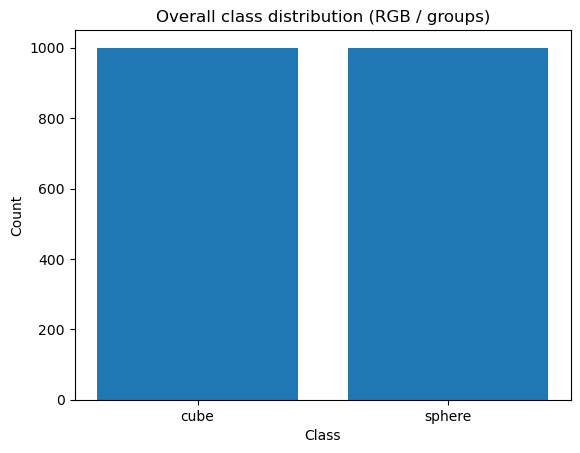

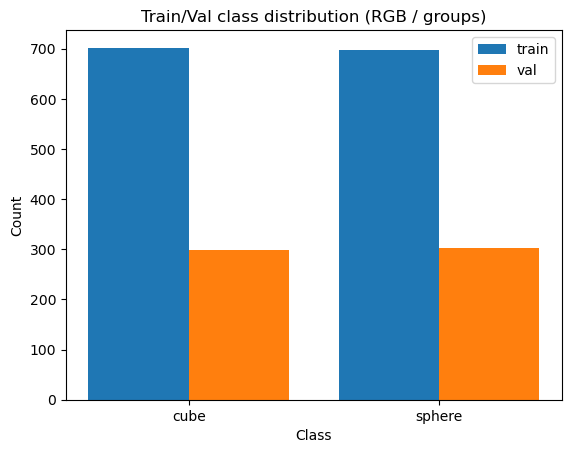

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import fiftyone as fo
from fiftyone import ViewField as F

ds = dataset
LABEL = "label.label"

# 1) Representative slice (1 sample per group)
rgb = ds.select_group_slices("rgb")
lidar = ds.select_group_slices("lidar")

# --- Total number of samples per class (as groups, via rgb slice) ---
total_per_class = rgb.count_values(LABEL)
print("Total samples per class (RGB/groups):", total_per_class)
print("Total groups:", len(rgb))
print("Total samples (all slices):", len(ds))

# --- Train/validation split sizes (as groups, via rgb slice tags) ---
train_rgb = rgb.match_tags("train")
val_rgb   = rgb.match_tags("val")

print("\nTrain groups:", len(train_rgb))
print("Val groups  :", len(val_rgb))
print("Train class counts:", train_rgb.count_values(LABEL))
print("Val class counts  :", val_rgb.count_values(LABEL))

img = Image.open(rgb.first().filepath)
print("\nImage shapes (top):", np.asarray(img).shape)
print("Image datatype (top):", np.asarray(img).dtype)
print(f"Lidar shape (top):", np.load(lidar.first().filepath).shape)
print(f"Lidar datatype (top):", np.load(lidar.first().filepath).dtype)

# --- Class distribution visualization (overall + train/val) ---
classes = sorted(total_per_class.keys())
overall_y = [total_per_class.get(c, 0) for c in classes]
train_y   = [train_rgb.count_values(LABEL).get(c, 0) for c in classes]
val_y     = [val_rgb.count_values(LABEL).get(c, 0) for c in classes]

# Plot 1: overall
plt.figure()
plt.bar(classes, overall_y)
plt.title("Overall class distribution (RGB / groups)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Plot 2: train vs val side-by-side
x = np.arange(len(classes))
w = 0.4
plt.figure()
plt.bar(x - w/2, train_y, width=w, label="train")
plt.bar(x + w/2, val_y,   width=w, label="val")
plt.xticks(x, classes)
plt.title("Train/Val class distribution (RGB / groups)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.show()


## Vizualization with fiftyone

In [8]:
# fiftyone session
session = fo.launch_app(dataset, auto=False)
print(session.url)

Session launched. Run `session.show()` to open the App in a cell output.
http://localhost:5151/


The default group "rgb" is displayed in fiftyone. The labels "cube" and "sphere" ara available. Also the train/val split is enforced by labels.
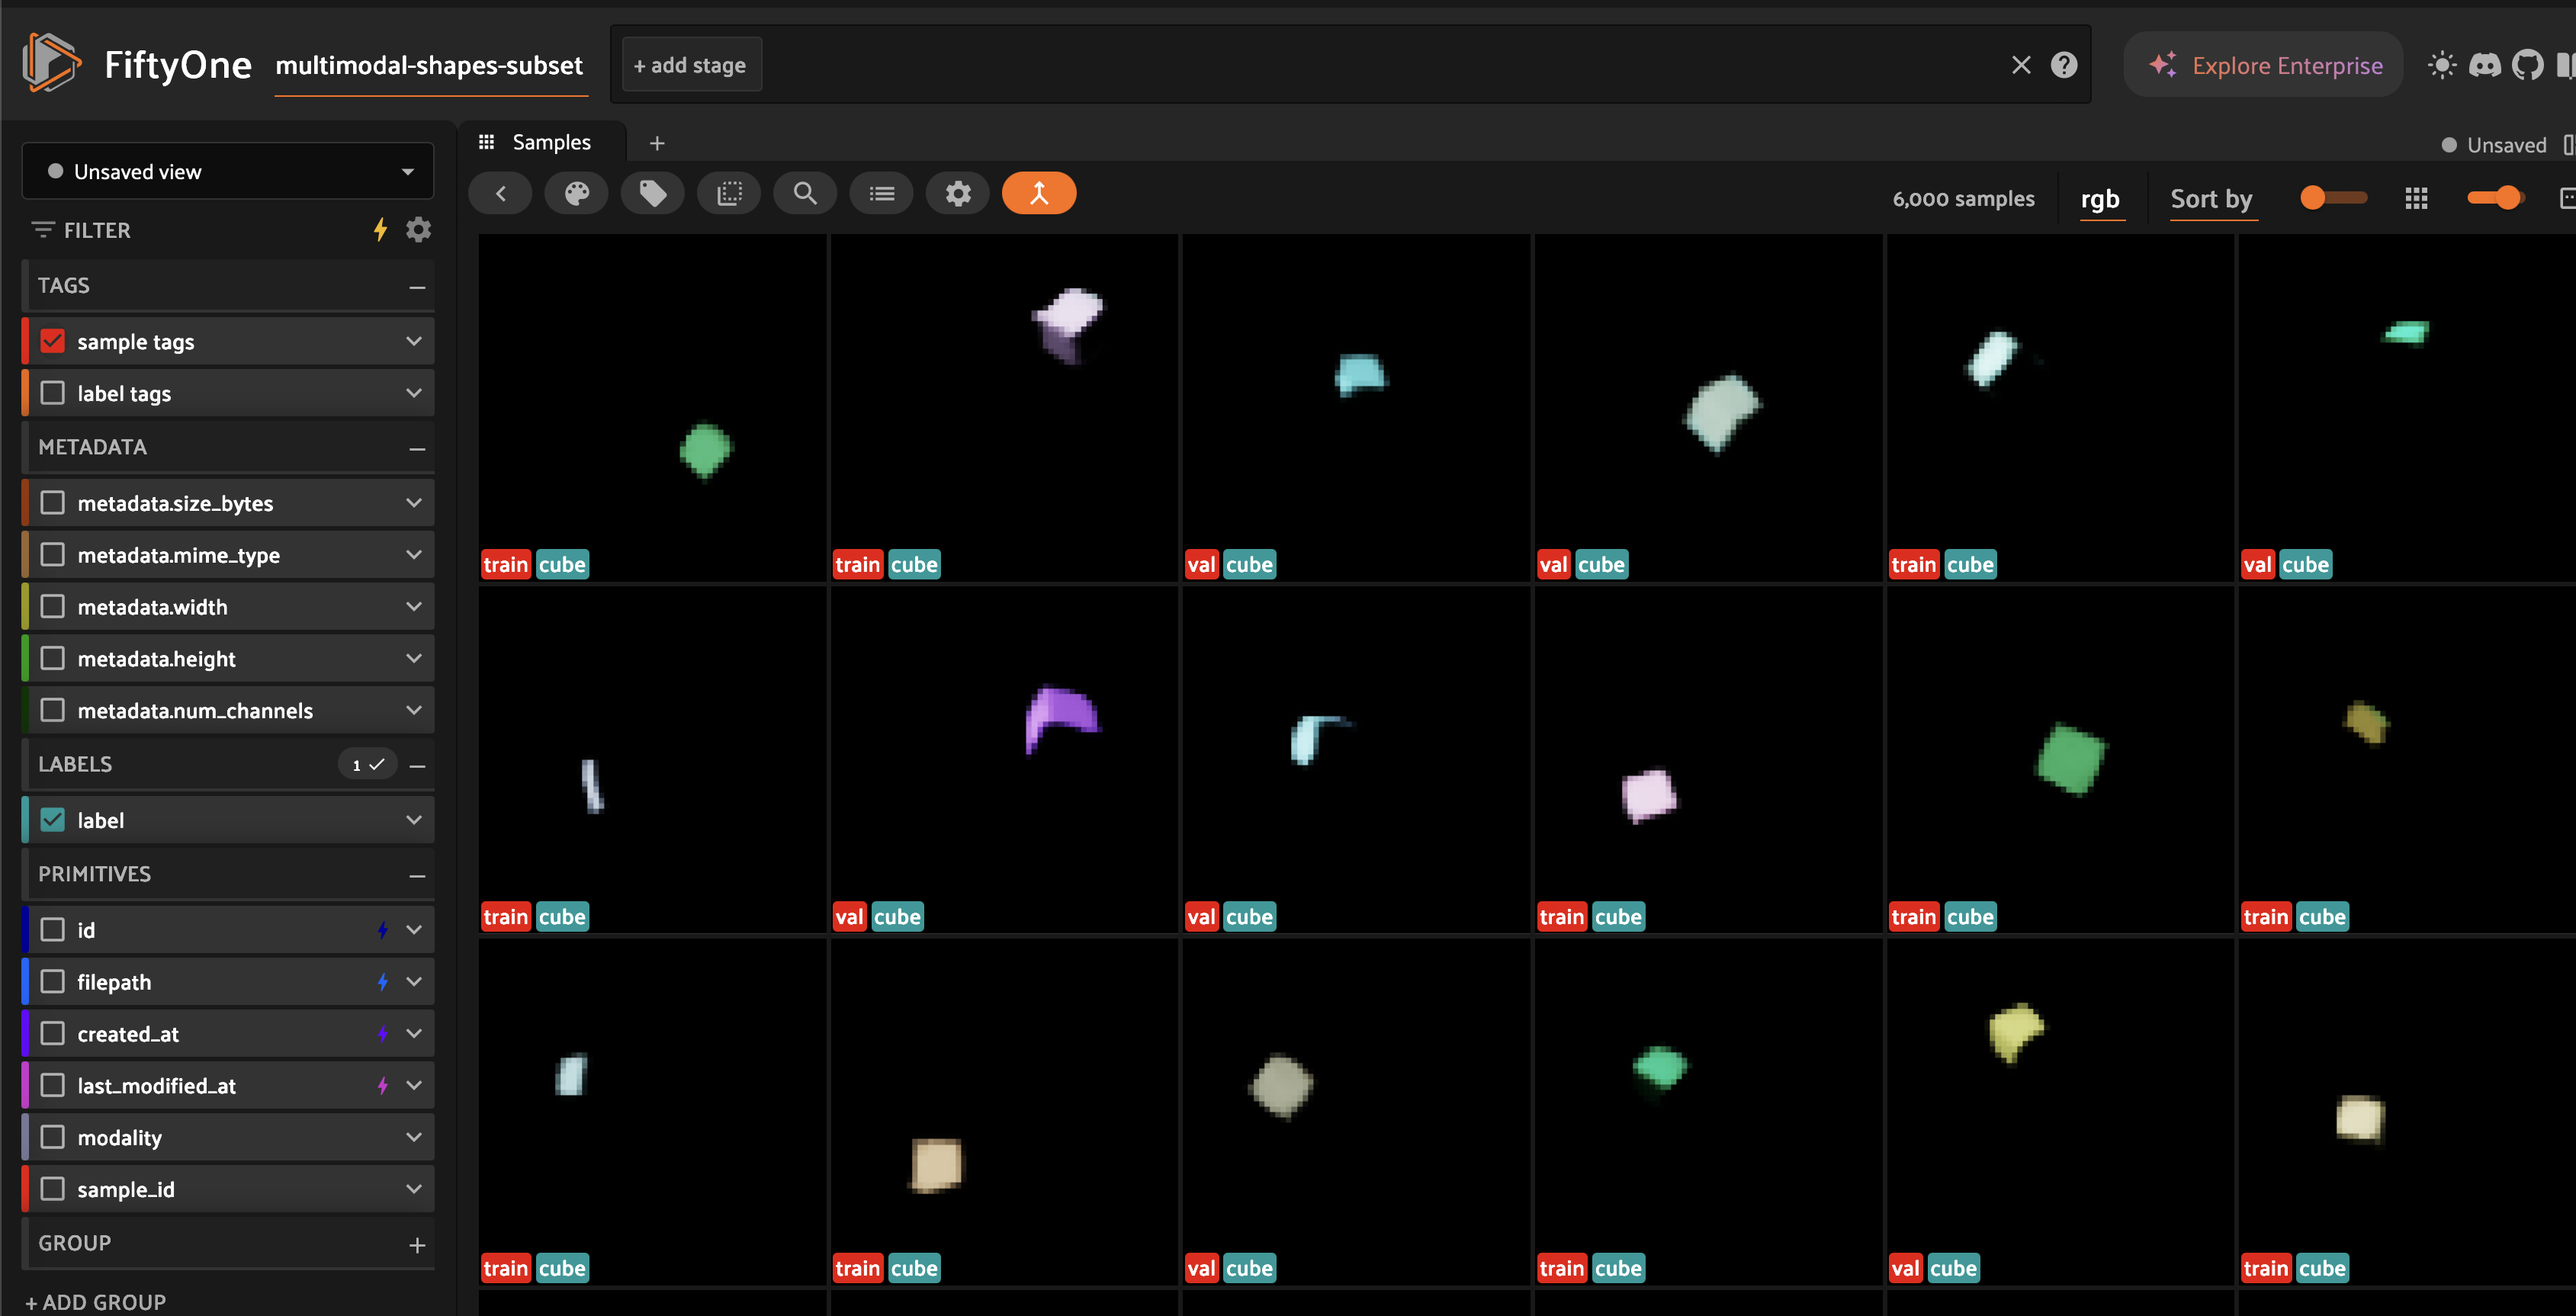

Each group has three Samples:
1. rgb (png file)
2. lidar (numpy array)
3. lidar as pcd file (used for visualization)

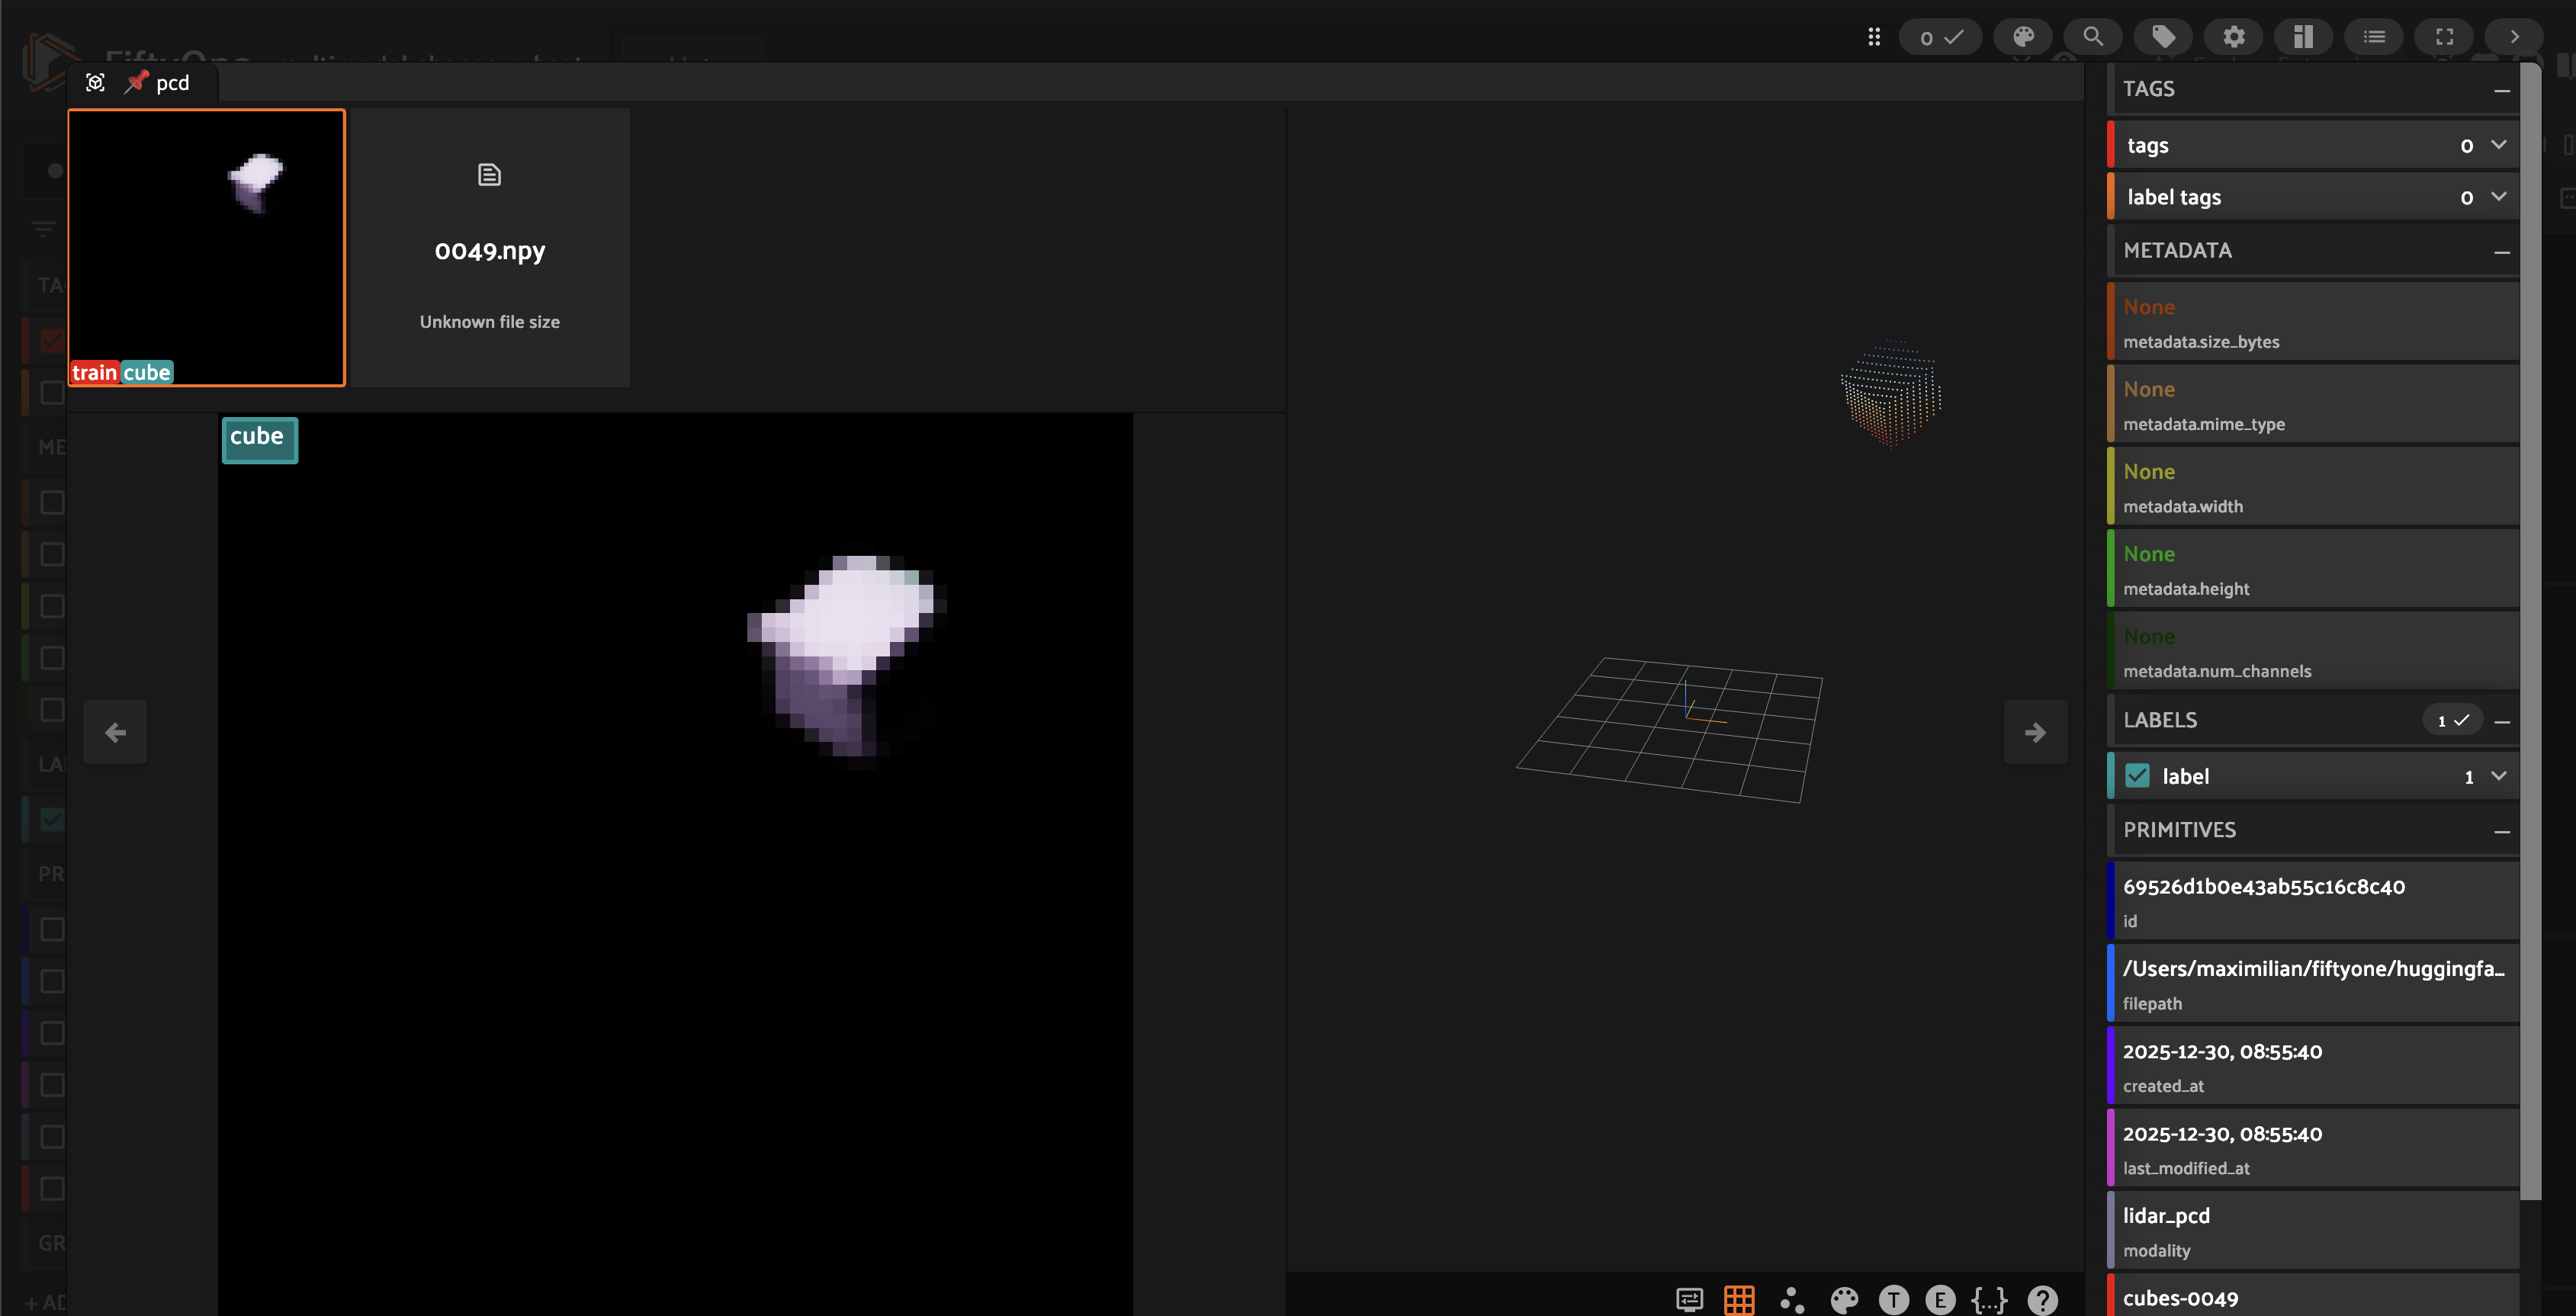

The original data from the kaggle source was not equally distributed. This was compensated during the integration into fiftyone by only taking a smaller subsample of the data. To achieve better results in training all available data should be used. 
Notably the Images are rgb. However the classification between cube and sphere does likely not depend on the objects color. The results might be improved by converting to grayscale. 
